In [1]:
############################################################################
#  Monyhly plots of SIC and Ice-free days - dayly data
############################################################################
# -------------------------------------------------------------------------
# First, select all the attributes listed for plotting
# 1. Load the SSS data (smos and topaz)
# 2. Calculate ice-free days / ice-covered days
# 3. Monthly free-ice days plot for the years selected
# -------------------------------------------------------------------------
# Author    : Maria Sanchez Urrea
# Email     : maria.sanchez.urrea@gmail.com
# Creation  : January 2023
############################################################################

month = 9
year_selection = [2011,2014,2016,2018]

show_plots = True  # Show plots in a window
#---------------------------------------------------------------------------

import xarray as xr
import numpy as np
import pandas as pd
import sys

import metpy
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import regionmask
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
from cmocean import cm

import calendar
from datetime import datetime
# Plot funciontions
from function_mackenzie_plots import plot_arctic_mackenzie_azimuthal_poly_BG
from function_mackenzie_plots import plot_arctic_mackenzie_azimuthal_poly_BG_c

# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

# Select attributes for plotting:

minl = 0
maxl = 30
bar_levels = [0,10,20,30]
cmap = cm.tools.crop_by_percent(cm.ice, 20, which='min', N=None)

# >> When using contourf:
cmap_free = ['#2A2A54','#2E2D5A','#373976','#3D4790','#4058A3','#3F6AAF','#417BB8',
'#4A8BBE','#589CC3','#68ADC9','#7BBED0','#90CDD6','#B1DDE1','#CDEBEE','#EDF9F9']

# >> Figure saved format (png, tiff, pdf) ---------
fs_format = 'png'

plt.rcParams["font.family"] = "serif"
mono_font = {'fontname':'monospace'} # for titles
fs        = 12 # fontsize


In [2]:
############################################################################
# 1. Data
############################################################################

path_save_fig = '/maps/'

# Pixel Area (km2) --------------------------------------------------------

path_area = '/Users/MUmbert/Library/Mobile Documents/com~apple~CloudDocs/Analysis/Curie/fwc/'
df_area = pd.read_csv(path_area+'area.csv',encoding = "ISO-8859-1",delimiter=';',decimal='.', header=None)
area = df_area.to_numpy()
area = area[0:95,:] # 95 is arctic circle (66.5 aprox.)

# SIC OSI SAF (daily data) ----------------------------------------------

path_sic = '/Users/MUmbert/Library/Mobile Documents/com~apple~CloudDocs/Analysis/Curie/fwc/'
filename = path_sic+'sic_osisaf_2011_2022_regrided_025.nc'

dset_sic = xr.open_dataset(filename);
sic = dset_sic.sic[:,0:95,:]
sic_time = dset_sic.time
sic_lat = dset_sic.lat[0:95]
sic_lon = dset_sic.lon

# Calculate total area covered by ice in each pixel
sic_km2 = np.zeros([len(sic_time),len(sic_lat),len(sic_lon)])

for i in  range(1,len(sic_time)+1,1):
    sic_km2[i-1,:,:] = sic[i-1,:,:]*area # np.array

# Convert result in xarray for better performing
sic_km2 = xr.DataArray(
    data=sic_km2,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], sic_lon.data),
        lat=(["lat"], sic_lat.data),
        time=sic_time.data,
    ),
    attrs=dict(
        standard_name="sea_ice_extension_by_pixel",
        long_name="Area covered by sea ice",
        units="km2",
        comment="this area results from SIC*pixel_area"
    ),
)

#print(sic_km2.shape)
#print(sic_km2)



(4289, 95, 1440)
<xarray.DataArray (time: 4289, lat: 95, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [6.60692314, 6.60557864, 6.60510032, ..., 6.59889621,
         6.59849222, 6.6079789 ],
        [9.91702091, 9.91725088, 9.91661375, ..., 9.90419087,
         9.90268785, 9.91780245],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [6.52522358, 6.52430254, 6.52423704, ..., 6.51607742,
         6.51608452, 6.52585944],
        [9.82651253, 9.82725512, 9.82713854, ..., 9.81225794,
         9.8112826 , 9.82677227],
...
        [       nan,        nan,        nan, ...

In [3]:
############################################################################
# 2. Calculate ice-free days / ice-covered days /sic monthly mean
############################################################################

# >> ice-free days (sic=0) ----------------------------------
sic_filtered = sic.where(sic==0) # where add by defaul a NA where the condition is not satified
# monthly mean of ice-free days
sic_free = sic_filtered.resample(time='MS').mean(dim='time', skipna=True, keep_attrs=True)
print(sic_free.shape)

# >> ice-covered days (sic>10%) ------------------------------
sic_positive = xr.where(sic>0.1,1,sic) # matriz of 1,<10 and NA
# calculate days of ice-covered area each month
sic_days = sic_positive.resample(time='MS').sum(dim='time', skipna=True, keep_attrs=True)
print(sic_days.shape)

# >> sic monthly mean ------------------------------
sic_monthly = sic.resample(time='MS').mean(dim='time', skipna=True, keep_attrs=True)
print(sic_monthly.shape)


(141, 95, 1440)
(141, 95, 1440)
(141, 95, 1440)


(12, 95, 1440)
2011


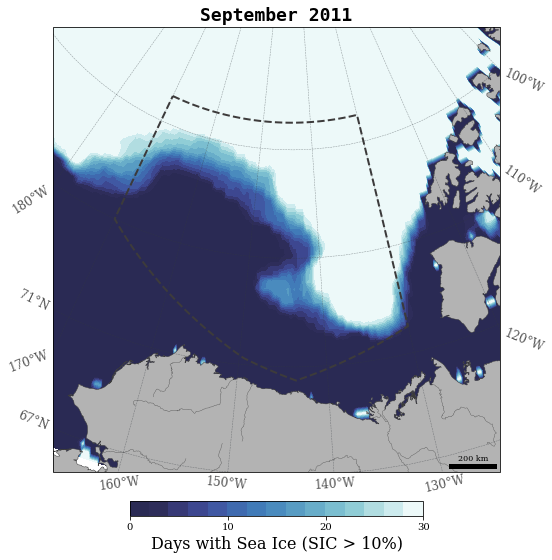

2014


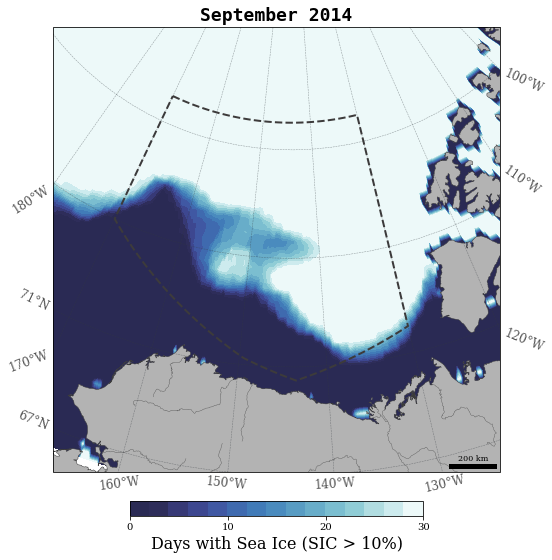

2016


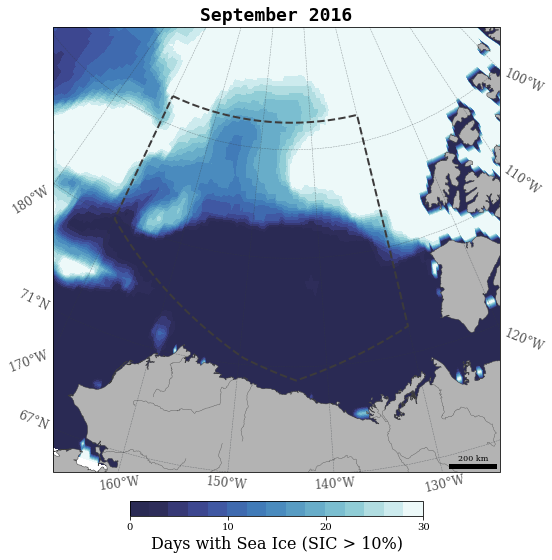

2018


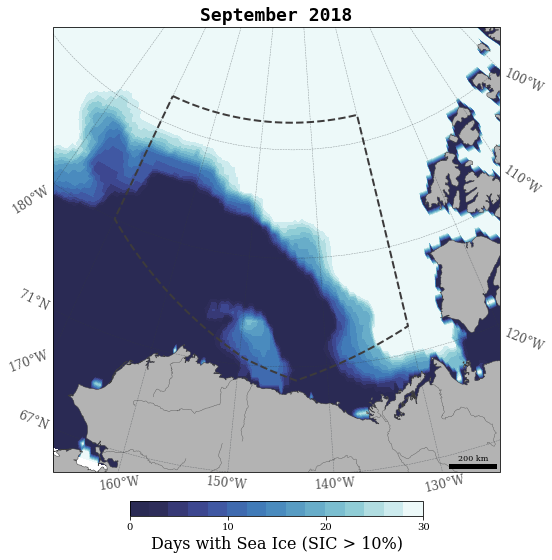

In [4]:
############################################################################
# 3. Plots monthly free-ice days
############################################################################

# Subset the pre-selected month:
sic_days_mm  = sic_days.sel(time=sic_days.time.dt.month.isin([month]))
print(sic_days_mm.shape)

# >> Free-ice days --------------------------------------------------------

for yy in year_selection:
    print(yy)

    # Subset year
    sic_days_mm_yy  = sic_days_mm.sel(time=sic_days_mm.time.dt.year.isin([yy])).squeeze()

    month_name = calendar.month_name[sic_days_mm_yy.time.dt.month.values]

    dd, llon = add_cyclic_point(sic_days_mm_yy.values, sic_days_mm_yy.lon)
    sic_days_mm_yy = xr.DataArray(dd, coords={'lat':sic_days_mm_yy.lat, 'lon':llon}, dims=('lat','lon'))

    # SMOS SSS
    fig = plot_arctic_mackenzie_azimuthal_poly_BG_c(darray = sic_days_mm_yy,
                                             ptitle = month_name +' ' + str(yy),
                                             ctitle = 'Days with Sea Ice (SIC > 10%)',
                                             minl=minl, maxl=maxl,
                                             levels=np.arange(0,32,2),
                                             cmap=cmap_free,
                                             blevels=bar_levels,
                                             clines=False,
                                             cformat=' {:.0f} ',
                                             cextend='neither',
                                             fs=fs)
    if show_plots:
        plt.show()
    else:
        fig.savefig(path_save_fig+'SIC_free_ice_days_'+month_name+'_'+str(yy)+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

(12, 95, 1440)
2011


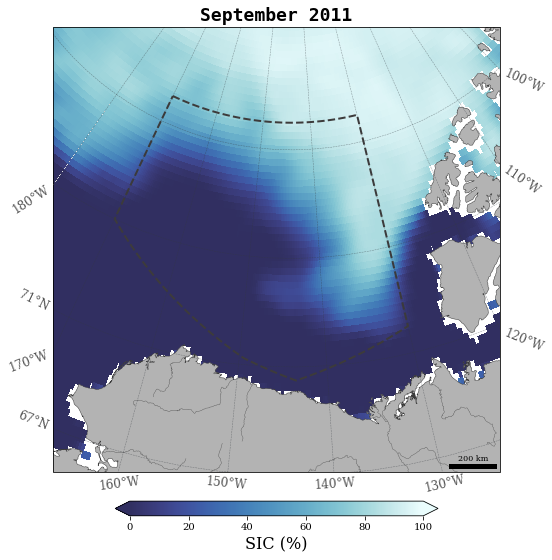

2014


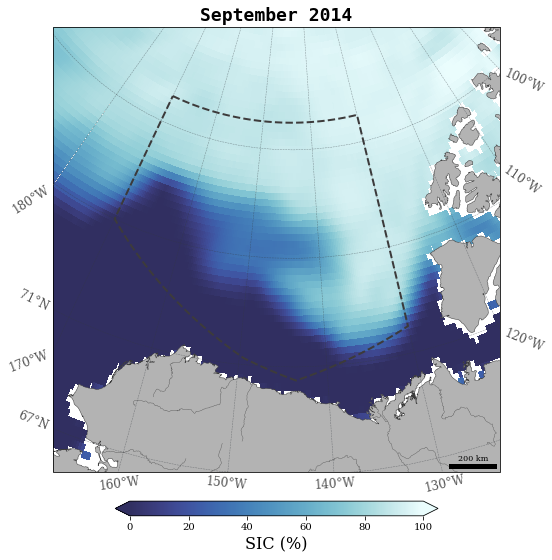

2016


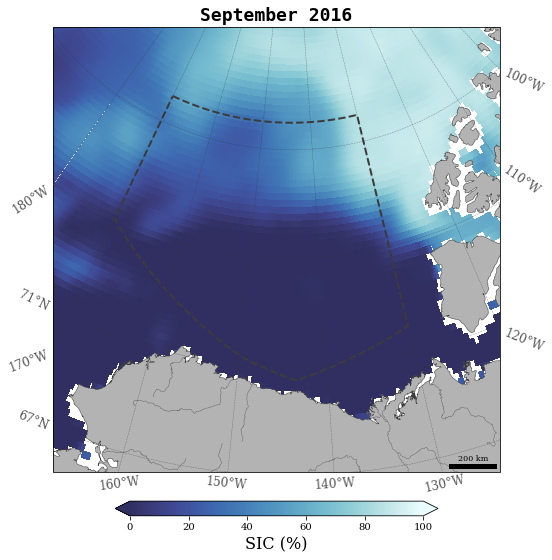

2018


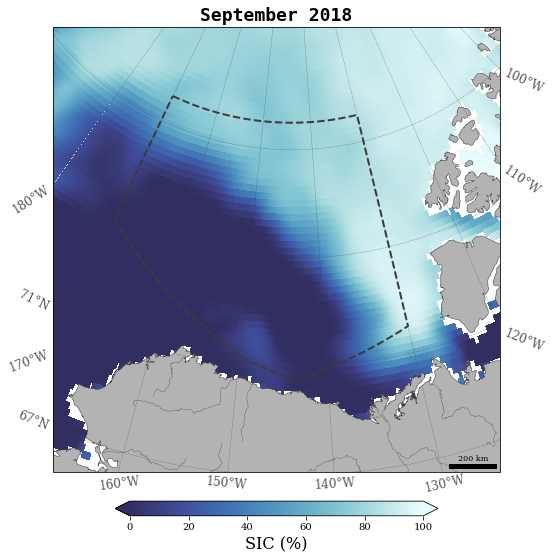

In [5]:
############################################################################
# 3. Plots monthly sic
############################################################################

# Subset the pre-selected month:
sic_mm  = sic_monthly.sel(time=sic_monthly.time.dt.month.isin([month]))
print(sic_mm.shape)

# >> SIC OSI SAF --------------------------------------------------------

for yy in year_selection:
    print(yy)

    # Subset year
    sic_mm_yy  = sic_mm.sel(time=sic_mm.time.dt.year.isin([yy])).squeeze()

    month_name = calendar.month_name[sic_mm_yy.time.dt.month.values]

    # 
    fig = plot_arctic_mackenzie_azimuthal_poly_BG(darray = sic_mm_yy*100,
                                             ptitle = month_name +' ' + str(yy),
                                             ctitle = 'SIC (%)',
                                             minl=0, maxl=100,
                                             cmap=cmap,
                                             blevels=[0,20,40,60,80,100],
                                             clines=False,
                                             cformat=' {:.0f} ',
                                             fs=fs)
    if show_plots:
        plt.show()
    else:
        fig.savefig(path_save_fig+'SIC_'+month_name+'_'+str(yy)+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)


In [ ]:
###########################################################################
# 4. Plots monthly Sep 2011 and Sep 2016 SSS + OSISAF
###########################################################################

# Subset the pre-selected month:
sic_mm  = sic_monthly.sel(time=sic_monthly.time.dt.month.isin([month]))
print(sic_mm.shape)

# >> SIC OSI SAF --------------------------------------------------------

for yy in year_selection:
    print(yy)

    # Subset year
    sic_mm_yy  = sic_mm.sel(time=sic_mm.time.dt.year.isin([yy])).squeeze()

    month_name = calendar.month_name[sic_mm_yy.time.dt.month.values]

    # 
    fig = plot_arctic_mackenzie_azimuthal_poly_BG(darray = sic_mm_yy*100,
                                             ptitle = month_name +' ' + str(yy),
                                             ctitle = 'SIC (%)',
                                             minl=0, maxl=100,
                                             cmap=cmap,
                                             blevels=[0,20,40,60,80,100],
                                             clines=False,
                                             cformat=' {:.0f} ',
                                             fs=fs)
    if show_plots:
        plt.show()
    else:
        fig.savefig(path_save_fig+'SIC_'+month_name+'_'+str(yy)+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)
